### The objective is to test some images and see the metric results

## Imports

In [1]:
## Imports

from src.PatchImageTool import PatchImageTool
from src.PytorchUtil import PytorchUtil as torchUtil
from src.UpscaleNN import UpscaleNN

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import src.nntools as nt
import skimage.metrics as metrics
import platform  # Import the platform module to detect the OS
import cv2
import math

device = None
if platform.system() == 'Windows':  # Check if the OS is Windows
    import torch_directml  # Import torch_directml only on Windows
    device = torch_directml.device()


if not device:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.empty_cache()
    else:
        device = torch.device('cpu')

print(device)

cuda


## Define the model

In [2]:
small_dataset = None
small_valid_dataset = None
stats_manager = None

lr = 1e-3
batch_size = 32

torch.cuda.empty_cache()
r = UpscaleNN() 
torch.cuda.empty_cache()
r = r.to(device)

path = "results/smallbatchexperiment-upscale2"

adam = torch.optim.Adam(r.parameters(), lr=lr)

def criterion(y, d):
    return F.mse_loss(y, d)

exp = nt.Experiment(r, small_dataset, small_valid_dataset, adam, stats_manager, device, criterion, batch_size=1,
                     output_dir=path, perform_validation_during_training=True)

## Load image and test

In [3]:
import torchvision.transforms as transforms

image_transforme = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

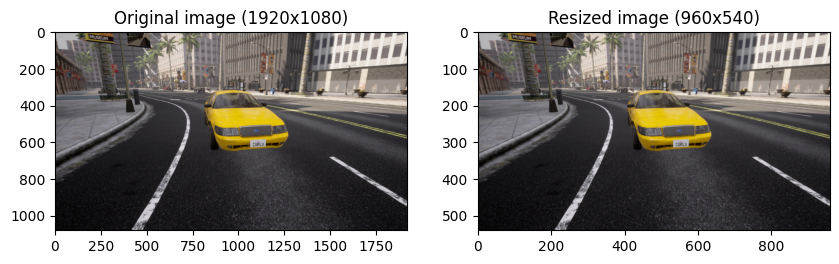

uint8


In [4]:
resources_path = "resources"

image_path = os.path.join(resources_path, "test/1920x1080/00021.png")
image = cv2.imread(image_path)
image_size = (image.shape[1], image.shape[0])

# divide image image by 2
resized_image = cv2.resize(image, (image_size[0] // 2, image_size[1] // 2))
new_image_size = (resized_image.shape[1], resized_image.shape[0])

# apply transform to image
image_tensor = image_transforme(image)
resized_tensor = image_transforme(resized_image)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(torchUtil.tensor_to_image(image_tensor))
ax[0].set_title(f"Original image ({image_size[0]}x{image_size[1]})")

ax[1].imshow(torchUtil.tensor_to_image(resized_tensor))
ax[1].set_title(f"Resized image ({new_image_size[0]}x{new_image_size[1]})")

plt.show()

print(image.dtype)

In [5]:
patch_size = 32

num_patch_width = math.ceil(new_image_size[0] / patch_size)
num_patch_height = math.ceil(new_image_size[1] / patch_size)

num_patch_total = num_patch_width * num_patch_height

resized_patches = PatchImageTool.get_patchs_from_image(resized_tensor, patch_size=patch_size)

print(image_tensor.shape, image_tensor.dtype, resized_patches.dtype)

print(resized_patches.shape, num_patch_width, num_patch_height, num_patch_total)


torch.Size([3, 1080, 1920]) torch.float32 torch.float32
torch.Size([510, 3, 32, 32]) 30 17 510


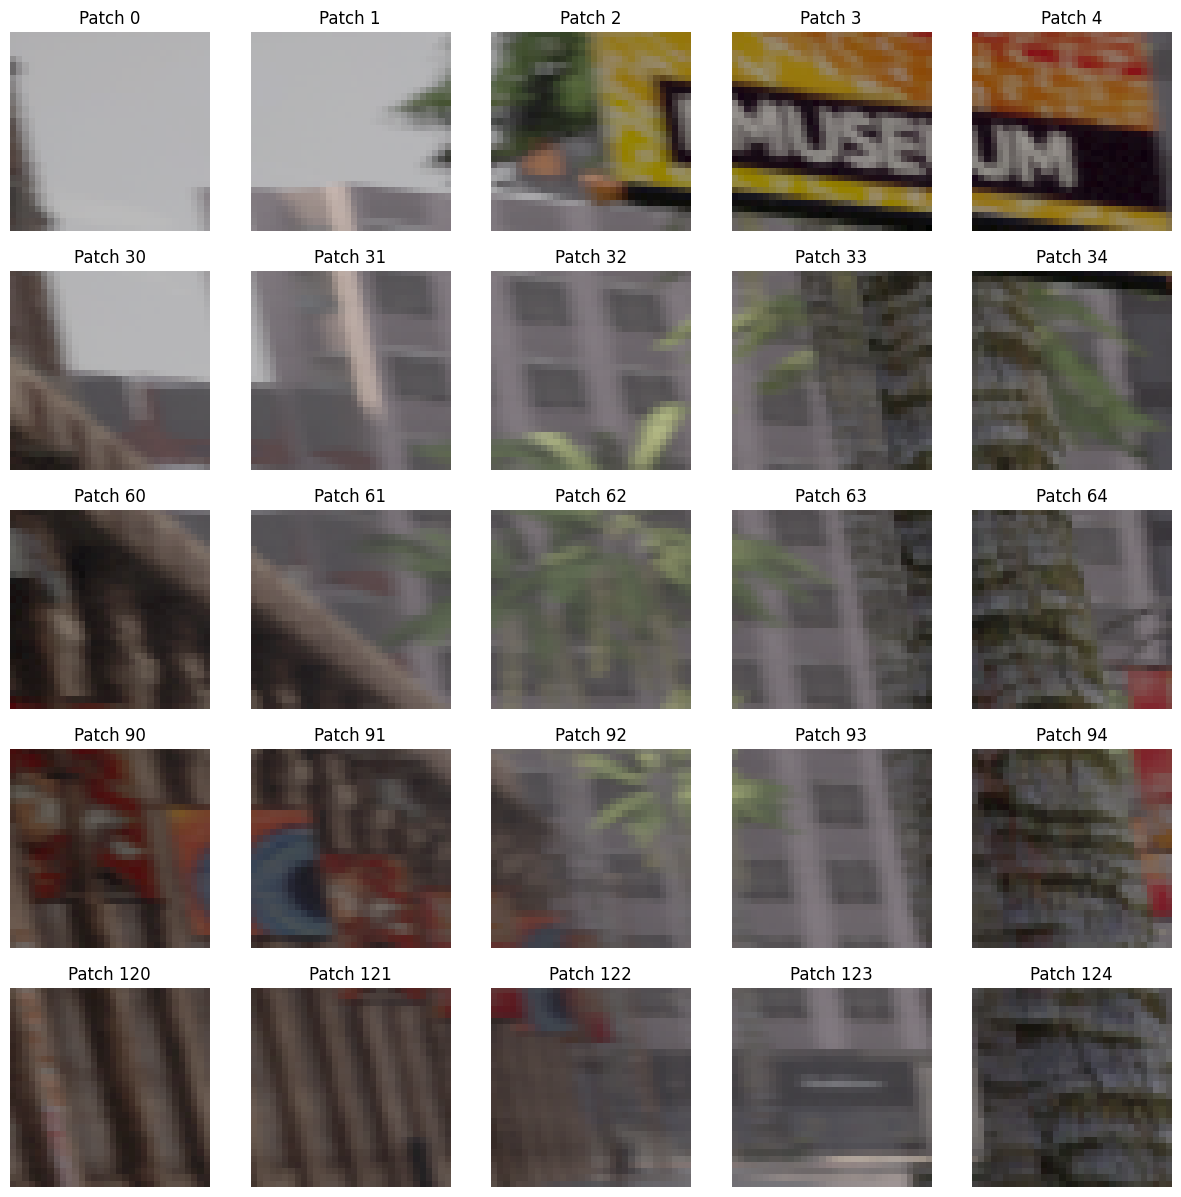

In [6]:
num_cols = min(5, num_patch_width)
num_rows = min(5, num_patch_height)


# Show some image patches
fig, ax = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))
for i in range(num_rows):
    for j in range(num_cols):
        # ndarray
        
        ax[i, j].imshow(torchUtil.tensor_to_image(resized_patches[i * num_patch_width + j]))
        ax[i, j].set_title(f"Patch {i * num_patch_width + j}")
        ax[i, j].axis('off')

Patch tensor size torch.Size([3, 32, 32]) type torch.float32
Prediction tensor size torch.Size([3, 64, 64]) type torch.float32


/home/maxence/miniconda3/envs/tf/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


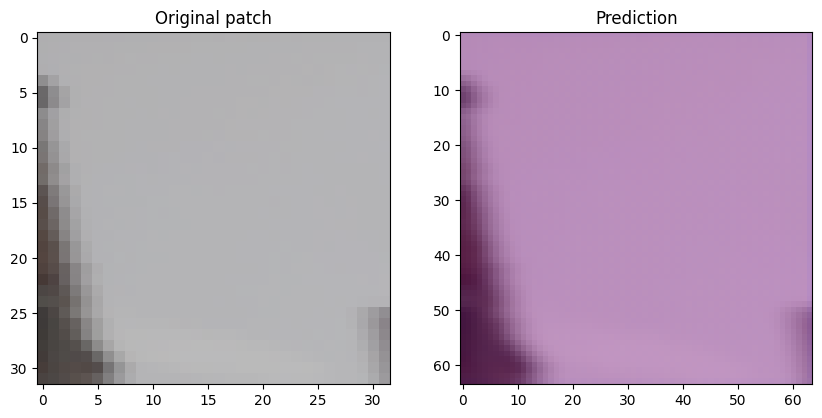

In [7]:
# Make the model predict one patch
patch_index = 0

patch = resized_patches[patch_index].to(device)
print("Patch tensor size", patch.shape, "type", patch.dtype)

with torch.no_grad():
    prediction = exp.net(patch)
    prediction = prediction.squeeze(0).cpu()

    print("Prediction tensor size", prediction.shape, "type", prediction.dtype)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(torchUtil.tensor_to_image(patch.squeeze(0).cpu()))
ax[0].set_title(f"Original patch")

ax[1].imshow(torchUtil.tensor_to_image(prediction.clamp(0, 1)))
ax[1].set_title(f"Prediction")

plt.show()

In [8]:
#image_upscaled_torch = exp.net(resized_tensor.to(device)).squeeze(0).cpu()
image_upscaled_torch = PatchImageTool.predict_image_from_image_patches(exp, image_size, resized_patches, device, patch_size=patch_size, sf=2)
# Clip the value of torch tensor to 0-1
image_upscaled_torch = torch.clamp(image_upscaled_torch, 0, 1)

image_to_show = torchUtil.tensor_to_image(image_tensor)
image_upscaled = torchUtil.tensor_to_image(image_upscaled_torch)

print(image.shape, resized_image.shape, image_upscaled.shape, image_upscaled_torch.dtype)

(1080, 1920, 3) (540, 960, 3) (1080, 1920, 3) torch.float32


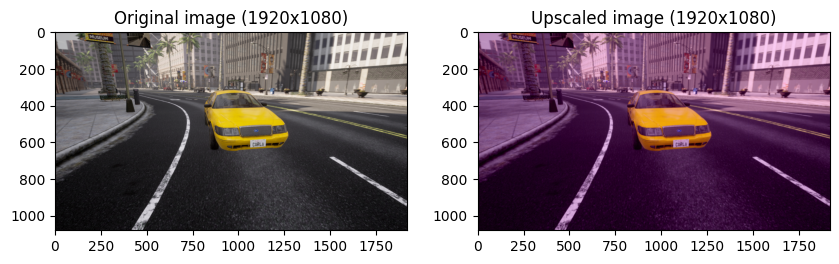

tensor(0.) tensor(0.9843)
tensor(0.) tensor(1.)


In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(image_to_show)
ax[0].set_title(f"Original image ({image_size[0]}x{image_size[1]})")

ax[1].imshow(image_upscaled)
ax[1].set_title(f"Upscaled image ({image_upscaled.shape[1]}x{image_upscaled.shape[0]})")

plt.show()

print(torch.min(image_tensor), torch.max(image_tensor))

print(torch.min(image_upscaled_torch), torch.max(image_upscaled_torch))

In [10]:
# Compute PSNR and SSIM
psnr = metrics.peak_signal_noise_ratio(torchUtil.tensor_to_numpy(image_tensor), torchUtil.tensor_to_numpy(image_upscaled_torch))
ssim = metrics.structural_similarity(torchUtil.tensor_to_numpy(image_tensor), torchUtil.tensor_to_numpy(image_upscaled_torch), \
                                     win_size=7, data_range=1, multichannel=True, channel_axis=2)

print(f"PSNR: {psnr} SSIM: {ssim}")

PSNR: 21.856229695371795 SSIM: 0.7879649996757507
